# multi-band constraints for HEB scenarios

* [gdoc](https://docs.google.com/document/d/1KAjtsJusj5CjAKTeHCdSD0_mW5XEurudQYAbRrBPqcE/edit#heading=h.5om452pqwk6i)
* See [timmy/multicolor.py](https://github.com/lgbouma/timmy/blob/master/timmy/multicolor.py)

In [1]:
import chronos as cr

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
import numpy as np

#isochrones analysis; see seidan/toi/toi0179/toi0179_stellar_characterization.ipynb
TEFF = 5231 #60
FEH = -0.02 #0.02
LOGG = 4.59
RSTAR = 0.78
MSTAR = 0.86

#TIC
# TEFF = 5081 #± 122.947
# LOGG  = 4.55845 #± 0.0872776
# FEH = -0.0202633 #± 0.0479623
# RSTAR = 0.838949 
# RSTAR = 0.777012 #gaia DR2
# MSTAR = 0.82 #starhorse catalog

LOG10AGE = np.log10(600e6) #my upper bound estimate
DELTA_OBS_TESS = 1134.54e-6 #from TIC

In [3]:
import matplotlib.pyplot as pl
import numpy as np
from scipy.interpolate import interp1d
#timmy/drivers/contrast_to_masslimit.py
import numpy as np
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy import constants as const

M_bol_sun = 4.83

# from isochrones.mist import MISTIsochroneGrid
# mist_iso_grid = MISTIsochroneGrid()

# def get_isochrones(age, feh, cols='Teff mass logL'.split(),
#                    age_tol=0.1, feh_tol=0.1
#                   ):
#     """
#     get Lstar, Teff, Mstar from isochrones given system age and metallicity
#     """
#     df = mist_iso_grid.df
#     #age
#     age_indices = df.index.get_level_values(0).unique()
#     nearest_age_index = np.argmin(np.abs(age_indices - age))
#     nearest_age = age_indices[nearest_age_index]
#     errmsg=f"{age:.2f}-{nearest_age:.2f}={age-nearest_age:.2f}<{age_tol}"
#     assert np.allclose(age, nearest_age, atol=age_tol), errmsg
#     #feh
#     feh_indices = df.index.get_level_values(1).unique()
#     nearest_feh_index = np.argmin(np.abs(feh_indices - feh))
#     nearest_feh = feh_indices[nearest_feh_index]
#     errmsg=f"{feh:.2f}-{nearest_feh:.2f}={feh-nearest_feh:.2f}<{feh_tol}"
#     assert np.allclose(feh, nearest_feh, atol=feh_tol), errmsg
    
#     df = df.loc[nearest_age, nearest_feh][cols].reset_index(drop=True)
#     return df

# def _find_nearest_index(df, param, value):
#     return np.argmin(np.abs(np.array(df[param]) - value))

from isochrones.mist import MIST_EvolutionTrack
mist_track = MIST_EvolutionTrack()

def get_isochrones(mass, log10age, feh, cols='Teff mass radius logL'.split()):
    """interpolate params"""
    eep = mist_track.get_eep(mass, log10age, feh)
    return mist_track.interp_value([mass, eep, feh], cols)   


def get_blackbody_functions(teffs, lums, wvlen):
    """
    returns dict for each component teff and lum
    """
    
    B_lambda_dict = {}
    for ix, (temperature, luminosity) in enumerate(zip(teffs*u.K, lums*u.Lsun)):
        bb = BlackBody(temperature=temperature)
        B_nu_vals = bb(wvlen)
        B_lambda_vals = (
            B_nu_vals * (const.c / wvlen**2)
        ).to(u.erg/u.nm/u.s/u.sr/u.cm**2)

        B_lambda_dict[ix] = B_lambda_vals
    return B_lambda_dict

def get_luminosity(teff, rstar):
    return (4*np.pi*(rstar*u.Rsun)**2 * const.sigma_sb*(teff*u.K)**4).to(u.Lsun).value
    
def get_rstar(teff, luminosity):
    return np.sqrt(
                luminosity /
                (4*np.pi * const.sigma_sb * teff**4)
            ).to(u.Rsun).value
    
def get_filter_transmissions(bandpasses):
    """
    bandpasses: list
        telescope/filter format
    """
    filter_transmissions = {}
    for bp in bandpasses:
        telescope, filter = bp.split('/')
        bpdf = cr.get_filter_transmission_from_SVO(filter, telescope)
        filter_transmissions[bp] = bpdf
    return filter_transmissions

def get_bolometric_magnitude_from_SED(teffs, lums, wav_nm, transmission):
    """
    """
    M_Xs = []
    for temperature, luminosity in zip(teffs*u.K, lums*u.Lsun):

        bb = BlackBody(temperature=temperature)

        wvlen = np.array(wav_nm)*u.nm
        B_nu_vals = bb(wvlen)
        B_lambda_vals = B_nu_vals * (const.c / wvlen**2)

        T_lambda = np.array(transmission)

        F_X = 4*np.pi*u.sr * np.trapz(B_lambda_vals * T_lambda, wvlen)

        F = const.sigma_sb * temperature**4

        # https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html
        M_bol_star = (
            -5/2 * np.log10(luminosity/(1*u.Lsun)) + M_bol_sun
        )

        # bolometric magnitude of the star, in the bandpass!
        M_X = M_bol_star - 5/2*np.log10( F_X/F )

        M_Xs.append(M_X.value)
    return M_Xs

def get_delta_obs_given_mstars(m2, m3, m1=MSTAR,
                               filter_transmissions,
                               make_plot=0, verbose=1):
    """
    Given a hierarchical eclipsing binary system (HEB),
    where Star 1 is the main source of light, 
    and Stars 2 and 3 are eclipsing,
    compute the observed eclipse depth of Star 3 in front of Star 2 in each of
    a number of bandpasses, assuming maximum large eclipses, and blackbodies.
    This also assumes MIST isochrones.
    
    Steps:
    * get Lstar, Teff, Mstar from isochrones given system age and metallicity
    * interpolate Lstar & Teff given component masses
    * compute blackbody functions given Teffs
    * get instrument filter transmission response function from SVO
    * integrate blackbody and transmission function using np.trapz
    * compute Fbol using integrated functions above
    * compute Rstar using stefan-boltzman law given isochronal Teff/Lstar
    * compute Lstar given Rstar and Fbol
    * compute depth from Lstar assuming tertiary eclipsing the secondary
    """
    assert isinstance(filter_transmissions, dict)
    
    mstars = np.array([m1, m2, m3])
    
#     #get Lstar, Teff, Mstar from isochrones given system age and metallicity
#     df_ic = get_isochrones(LOG10AGE, FEH)
#     df_ic['lum'] = 10**(df_ic.logL)

#     #interpolate Lstar & Teff given component masses
#     m1_idx = _find_nearest_index(df_ic, 'mass', m1)
#     m2_idx = _find_nearest_index(df_ic, 'mass', m2)
#     m3_idx = _find_nearest_index(df_ic, 'mass', m3)
    
#     teff1 = TEFF #teff1 = df_ic.loc[m1_idx, 'Teff']
#     teff2 = df_ic.loc[m2_idx, 'Teff']
#     teff3 = df_ic.loc[m3_idx, 'Teff']

#     lum1 = get_luminosity(teff1, RSTAR) #lum1 = df_ic.loc[m1_idx, 'lum']
#     lum2 = df_ic.loc[m2_idx, 'lum']
#     lum3 = df_ic.loc[m3_idx, 'lum']
    teff1, mass, radius, logL1 = get_isochrones(m1, LOG10AGE, FEH, 
                                          cols='Teff mass radius logL'.split()
                                         )
    lum1 = 10**(logL)
    teff2, mass, radius, logL2 = get_isochrones(m2, LOG10AGE, FEH, 
                                              cols='Teff mass radius logL'.split()
                                             )
    lum2 = 10**(logL2)
    teff3, mass, radius, logL3 = get_isochrones(m3, LOG10AGE, FEH, 
                                              cols='Teff mass radius logL'.split()
                                             )
    lum3 = 10**(logL3)

    teffs = np.array([teff1, teff2, teff3])
    lums = np.array([lum1, lum2, lum3])
    
    #compute blackbody functions given Teffs
    wvlen = np.logspace(1, 5, 2000)*u.nm
    B_lambda_dict = get_blackbody_functions(teffs, lums, wvlen)

    # get the flux in each bandpass
    F_X_dict = {}
    F_dict = {}
    M_X_dict = {}
    M_dict = {}
    T_dict = {}
    L_X_dict = {}
    bandpasses = list(filter_transmissions.keys())
    for bp in bandpasses:
        # get filter transmission from SVO
        bpdf = filter_transmissions[bp]
        
        
        bp_wvlen = np.array(bpdf['wav_nm'])
        T_lambda = np.array(bpdf.transmission)
        if np.nanmax(T_lambda) > 1.1:
            if np.nanmax(T_lambda) < 100:
                T_lambda /= 100 # unit convert
            else:
                raise NotImplementedError

        eps = 1e-6
        if not np.all(np.diff(bp_wvlen) > eps):
            raise NotImplementedError

        interp_fn = interp1d(bp_wvlen, T_lambda, bounds_error=False,
                             fill_value=0, kind='quadratic')

        T_lambda_interp = interp_fn(wvlen)
        T_dict[bp] = T_lambda_interp

        F_X_dict[bp] = {}
        M_X_dict[bp] = {}
        L_X_dict[bp] = {}

        #
        # for each star, calculate erg/s in bandpass
        # NOTE: the quantity of interest is in fact counts/sec. 
        # (this is probably a small consideration, but could still be worth
        # checking)
        #

        rstars = []
        for ix, (temperature, luminosity) in enumerate(zip(teffs*u.K, lums*u.Lsun)):

            # flux (erg/s/cm^2) in bandpass
            _F_X = (
                4*np.pi*u.sr *
                np.trapz(B_lambda_dict[ix] * T_lambda_interp, wvlen)
            )

            F_X_dict[bp][ix] = _F_X

            # bolometric flux, according to the blackbody function
            _F_bol = (
                4*np.pi*u.sr * np.trapz(B_lambda_dict[ix] *
                                     np.ones_like(T_lambda_interp), wvlen)
            )

            # stefan-boltzman law to get rstar from the isochronal temp/lum.
            rstar = get_rstar(temperature, luminosity)
            rstars.append(rstar)

            # erg/s in bandpass
            _L_X = _F_X * 4*np.pi * rstar**2

            L_X_dict[bp][ix] = _L_X.cgs

            if DEBUG:
                print(42*'-')
                print(f'{_F_X:.2e}, {_F_bol:.2e}, {L_X_dict[bp][ix]:.2e}')

            if ix not in F_dict.keys():
                F_dict[ix] = _F_bol

            # get bolometric magnitude of the star, in the bandpass, as a
            # sanity check
            M_bol_star = (
                -5/2 * np.log10(luminosity/(1*u.Lsun)) + M_bol_sun
            )
            M_X = M_bol_star - 5/2*np.log10( F_X_dict[bp][ix]/F_dict[ix] )

            if ix not in M_dict.keys():
                M_dict[ix] = M_bol_star.value

            M_X_dict[bp][ix] = M_X.value


    delta_obs_dict = {}
    for k in L_X_dict.keys():

        # out of eclipse
        L_ooe = L_X_dict[k][0] + L_X_dict[k][1] + L_X_dict[k][2]

        # in eclipse. assume maximum depth
        f = (rstars[2]/rstars[1])**2
        L_ie = L_X_dict[k][0] + L_X_dict[k][2] + (1-f)*L_X_dict[k][1]

        # assume the tertiary is eclipsing the secondary.
        delta_obs_dict[k] = (
            (L_ooe - L_ie)/L_ooe
        ).value

    if verbose:
        for k in delta_obs_dict.keys():
            print(f'{k}: {delta_obs_dict[k]:.2e}')

    if make_plot:
        from astropy.visualization import quantity_support
        pl.close('all')
        linestyles = ['-','-','--']
        f, ax = pl.subplots(figsize=(8,6))
        with quantity_support():
            for ix in range(3):
                l = f'{teffs[ix]:.0f} K, {mstars[ix]:.3f} M$_\odot$'
                ax.plot(wvlen, B_lambda_dict[ix], ls=linestyles[ix],
                        label=l)
        ax.set_yscale('log')
        ax.set_ylim([1e-3,10*np.nanmax(np.array(list(B_lambda_dict.values())))])
        ax.set_xlabel('Wavelength [nm]')
        ax.legend(loc='best')#, fontsize='xx-small')

        ax.set_ylabel('$B_\lambda$ [erg nm$^{-1}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$ ]')
        tax = ax.twinx()
        tax.set_ylabel('Transmission [%]')
        for k in T_dict.keys():
            sel = T_dict[k] > 0
            tax.plot(wvlen[sel], 100*T_dict[k][sel], c='k', lw=0.5)
        tax.set_xscale('log')
        tax.set_ylim([0,105])

        ax.set_xlim([5e1, 1.1e4])

        f.tight_layout()

    return delta_obs_dict

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


## isochrones

In [4]:
# df_ic = get_isochrones(LOG10AGE, FEH)
# df_ic['lum'] = 10**(df_ic.logL)
# df_ic

In [5]:
teff, mass, radius, logL = get_isochrones(MSTAR, LOG10AGE, FEH, 
                                          cols='Teff mass radius logL'.split()
                                         )
teff, mass, radius, logL

(5222.216541598857,
 0.8599902338385418,
 0.7708250395867259,
 -0.4007030497472649)

## filter transmissions

Querying http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=TESS
Querying http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=LasCumbres&gname2=LasCumbres
Querying http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=LasCumbres&gname2=LasCumbres


Text(0, 0.5, 'Transmission')

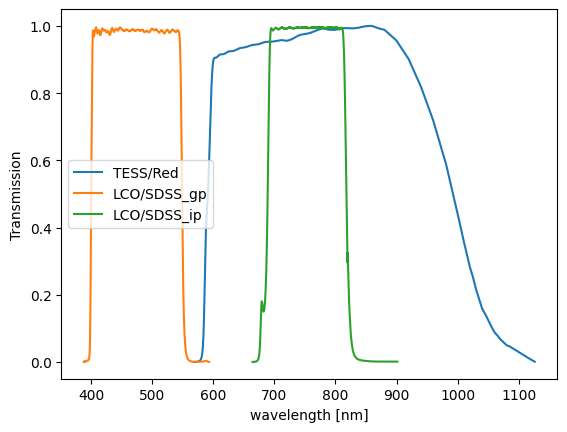

In [6]:
filter_transmissions = {}
t = cr.get_filter_transmission_from_SVO('Red', 'TESS')
g = cr.get_filter_transmission_from_SVO('SDSS_gp', 'LasCumbres', 'LasCumbres') 
i = cr.get_filter_transmission_from_SVO('SDSS_ip', 'LasCumbres', 'LasCumbres') 

filter_transmissions['TESS/Red'] = t
filter_transmissions['LCO/SDSS_gp'] = g
filter_transmissions['LCO/SDSS_ip'] = i

ax = t.plot(x='wav_nm', y='transmission', label='TESS/Red')
_ = g.plot(ax=ax, x='wav_nm', y='transmission', label='LCO/SDSS_gp')
_ = i.plot(ax=ax, x='wav_nm', y='transmission', label='LCO/SDSS_ip')

ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('Transmission')

In [7]:
filter_transmissions

{'TESS/Red':      wav_nm  transmission
 1     568.0      0.000104
 2     569.0      0.000136
 3     570.0      0.000182
 4     571.0      0.000245
 5     572.0      0.000337
 ..      ...           ...
 555  1122.0      0.004797
 556  1123.0      0.003748
 557  1124.0      0.002706
 558  1125.0      0.001673
 559  1126.0      0.000648
 
 [559 rows x 2 columns],
 'LCO/SDSS_gp':          wav_nm  transmission
 0     388.29999        0.0001
 1     388.47998        0.0003
 2     388.66000        0.0008
 3     388.84000        0.0016
 4     389.01999        0.0024
 ...         ...           ...
 1135  592.59998        0.0003
 1136  592.78003        0.0002
 1137  592.96002        0.0002
 1138  593.14001        0.0001
 1139  593.32001        0.0001
 
 [1140 rows x 2 columns],
 'LCO/SDSS_ip':          wav_nm  transmission
 0     664.23999        0.0001
 1     664.41998        0.0001
 2     664.59998        0.0001
 3     664.78003        0.0001
 4     664.96002        0.0001
 ...         ...     

## blackbodies

(100.0, 2000.0)

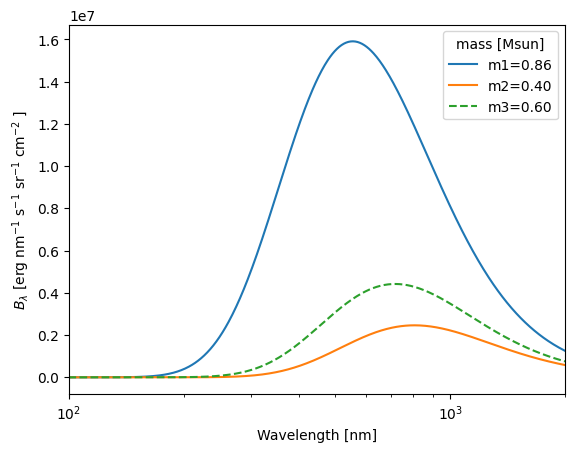

In [8]:
#interpolate Lstar & Teff given component masses

m1, m2, m3 = MSTAR, 0.4, 0.6

mstars = np.array([m1, m2, m3])
    
# #get Lstar, Teff, Mstar from isochrones given system age and metallicity
# df_ic = get_isochrones(LOG10AGE, FEH)
# df_ic['lum'] = 10**(df_ic.logL)

# #interpolate Lstar & Teff given component masses
# m1_idx = _find_nearest_index(df_ic, 'mass', m1)
# m2_idx = _find_nearest_index(df_ic, 'mass', m2)
# m3_idx = _find_nearest_index(df_ic, 'mass', m3)

# teff1 = df_ic.loc[m1_idx, 'Teff'] #TEFF
# teff2 = df_ic.loc[m2_idx, 'Teff']
# teff3 = df_ic.loc[m3_idx, 'Teff']

# lum1 = df_ic.loc[m1_idx, 'lum']#get_luminosity(teff1, RSTAR)
# lum2 = df_ic.loc[m2_idx, 'lum']
# lum3 = df_ic.loc[m3_idx, 'lum']
teff1, mass, radius, logL1 = get_isochrones(m1, LOG10AGE, FEH, 
                                          cols='Teff mass radius logL'.split()
                                         )
lum1 = 10**(logL)
teff2, mass, radius, logL2 = get_isochrones(m2, LOG10AGE, FEH, 
                                          cols='Teff mass radius logL'.split()
                                         )
lum2 = 10**(logL2)
teff3, mass, radius, logL3 = get_isochrones(m3, LOG10AGE, FEH, 
                                          cols='Teff mass radius logL'.split()
                                         )
lum3 = 10**(logL3)

teffs = np.array([teff1, teff2, teff3])
lums = np.array([lum1, lum2, lum3])

#compute blackbody functions given Teffs
wvlen = np.logspace(1, 5, 2000)*u.nm
B_lambda_dict = get_blackbody_functions(teffs, lums, wvlen)

pl.plot(wvlen, B_lambda_dict[0], label=f'm1={m1:.2f}')
pl.plot(wvlen, B_lambda_dict[1], label=f'm2={m2:.2f}')
pl.plot(wvlen, B_lambda_dict[2], ls='--', label=f'm3={m3:.2f}')
pl.xscale('log')
pl.legend(title='mass [Msun]')
pl.xlabel('Wavelength [nm]')
pl.ylabel('$B_\lambda$ [erg nm$^{-1}$ s$^{-1}$ sr$^{-1}$ cm$^{-2}$ ]')
pl.xlim(1e2,2e3)

## bolometric flux

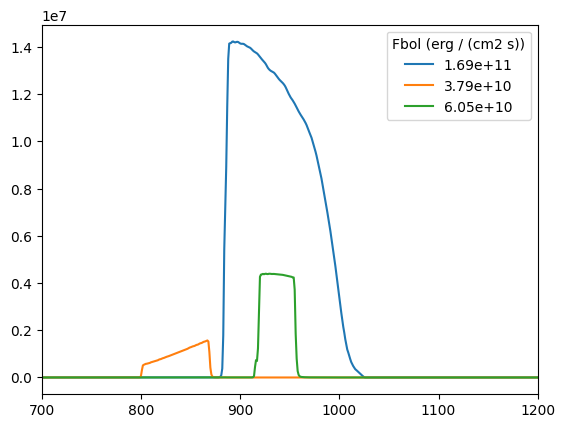

In [9]:
for ix,bp in enumerate(filter_transmissions):
    bpdf = filter_transmissions[bp]
    bp_wvlen = np.array(bpdf['wav_nm'])
    T_lambda = np.array(bpdf.transmission)
    #interpolate
    interp_fn = interp1d(bp_wvlen, T_lambda, bounds_error=False,
                         fill_value=0, kind='quadratic')
    T_lambda_interp = interp_fn(wvlen)
    #flux
    _F_X = 4*np.pi*u.sr * np.trapz(B_lambda_dict[ix] * T_lambda_interp, wvlen)
    # bolometric flux, according to the blackbody function
    _F_bol = 4*np.pi*u.sr * np.trapz(B_lambda_dict[ix] * np.ones_like(T_lambda_interp), wvlen)
    
    pl.plot(B_lambda_dict[ix] * T_lambda_interp, label=f'{_F_bol.value:.2e}')
pl.xlim(7e2,1.2e3)
pl.legend(title=f'Fbol ({_F_bol.unit})')

## maximum eclipse depths

In [10]:
colors = {
    'TESS/Red': 'r',
    'LCO/SDSS_gp': 'b',
    'LCO/SDSS_ip': 'g',
}

def plot_depth_per_passband(depths, filter_transmissions, masses):
    m1,m2,m3 = masses
    
    bp = 'TESS/Red'
    df = filter_transmissions[bp]
    ax = df.plot(x='wav_nm', y='transmission', ls='--', c=colors[bp], label=bp)

    bandpasses = list(filter_transmissions.keys())
    for bp in bandpasses[1:]:
        df = filter_transmissions[bp]
        df.plot(ax=ax, x='wav_nm', y='transmission', ls='--', c=colors[bp], label=bp)
    ax.set_xlabel('wavelength [nm]')
    ax.set_ylabel('Transmission')
    ax.set_title(f'm1={m1}, m2={m2}, m3={m3} [Msun]')
    ax.set_ylim(0,1)

    tax = ax.twinx()
    tax.set_ylabel('Eclipse Depth')
    for bp in bandpasses:
        x1 = filter_transmissions[bp].wav_nm.min()
        x2 = filter_transmissions[bp].wav_nm.max()
        tax.hlines(depths[bp], x1, x2, color=colors[bp])
    tax.set_xscale('log')
    tax.set_ylim(0,1)
    return ax

### equal mass triple star system

TESS/Red: 2.95e-02
LCO/SDSS_gp: 5.82e-03
LCO/SDSS_ip: 2.68e-02


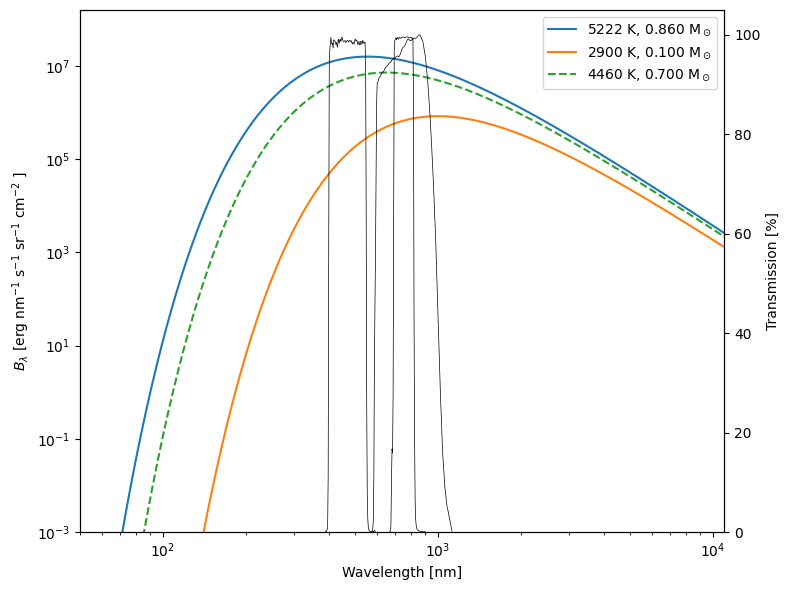

In [11]:
DEBUG = False

m2, m3 = 0.1, 0.7
depths = get_delta_obs_given_mstars(m2, m3, MSTAR,
                                    filter_transmissions,
                                    make_plot=True,
                                    verbose=True
                                   )

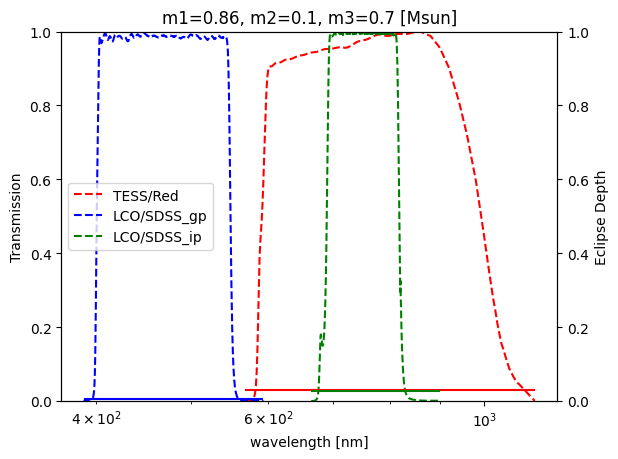

In [12]:
ax = plot_depth_per_passband(depths, filter_transmissions, [MSTAR,m2,m3])

### low-mass companions

TESS/Red: 8.37e-02
LCO/SDSS_gp: 3.53e-02
LCO/SDSS_ip: 8.10e-02


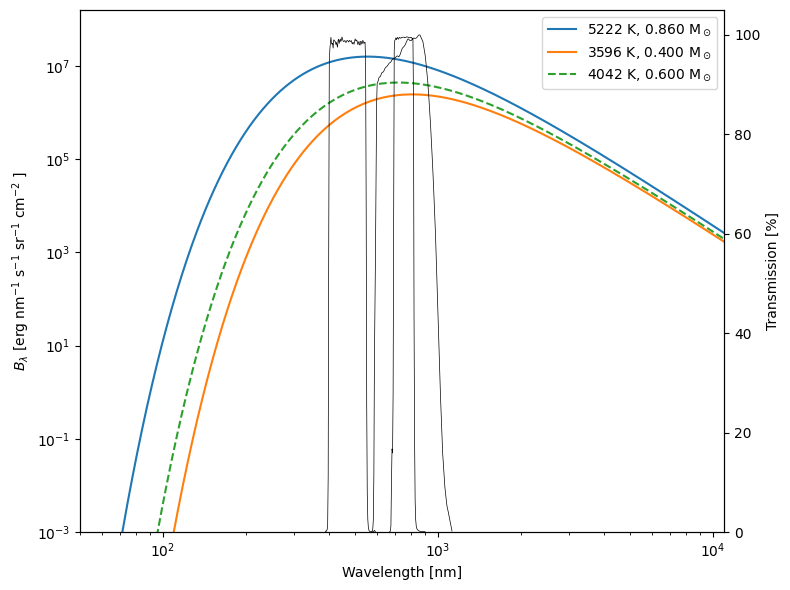

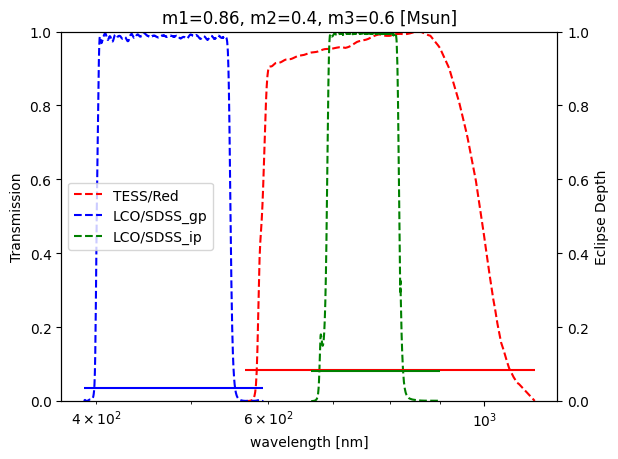

In [13]:
m2, m3 = 0.4, 0.6
depths = get_delta_obs_given_mstars(m2, m3, MSTAR,
                                    filter_transmissions,
                                    make_plot=True,
                                    verbose=True
                                   )

ax = plot_depth_per_passband(depths, filter_transmissions, [MSTAR,m2,m3])

For a typical HEB system with low-mass companion, the g-band produces an eclipse roughly 2 times shallower than in z-band, because the M-dwarf blackbody function emits more energy (roughly factor of 10) at longer wavelengths than the G-dwarf blackbody.

### higher-mass companions

TESS/Red: 3.79e-01
LCO/SDSS_gp: 3.33e-01
LCO/SDSS_ip: 3.79e-01


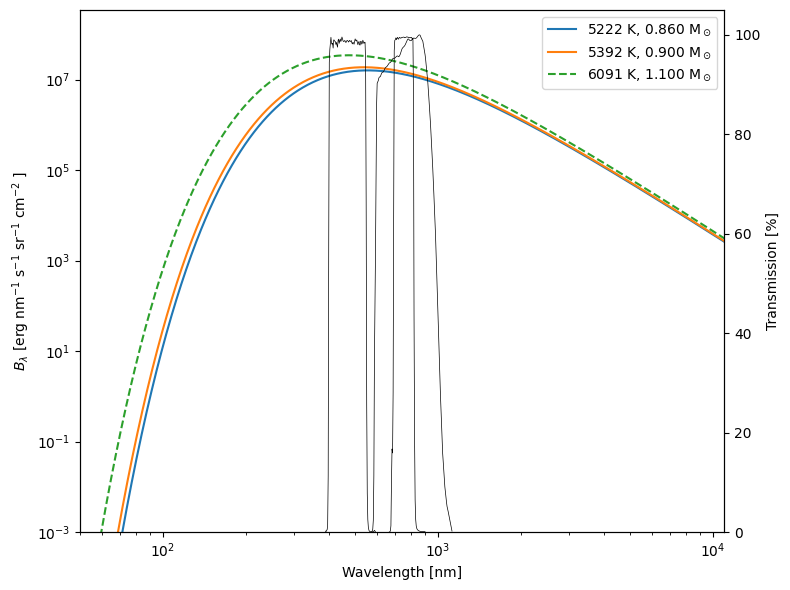

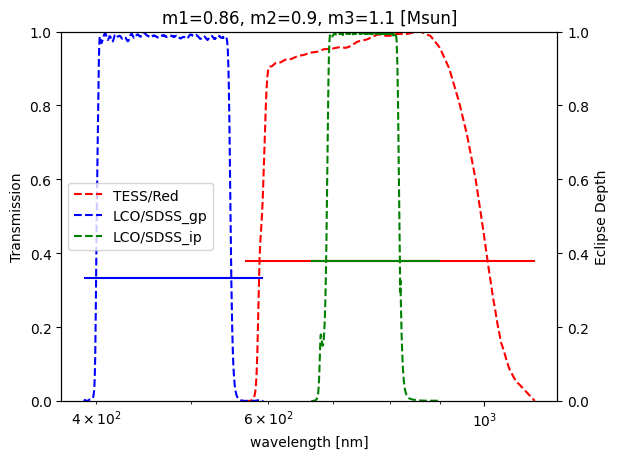

In [14]:
m2, m3 = 0.9, 1.1
depths = get_delta_obs_given_mstars(m2, m3, MSTAR,
                                    filter_transmissions,
                                    make_plot=True,
                                    verbose=True
                                   )

ax = plot_depth_per_passband(depths, filter_transmissions, [MSTAR,m2,m3])

## mass grid

In [15]:
from tqdm import tqdm

N_samples = 20

m2s = np.linspace(0.1, 1.10, N_samples)
m3s = np.linspace(0.1, 1.10, N_samples)

mass_grid_tess = np.zeros((N_samples,N_samples))
mass_grid_g = np.zeros((N_samples,N_samples))
mass_grid_i = np.zeros((N_samples,N_samples))

for i,m2 in tqdm(enumerate(m2s)): 
    for j,m3 in enumerate(m3s):
        depths = get_delta_obs_given_mstars(m2, m3, MSTAR,
                                            filter_transmissions,
                                            make_plot=False,
                                            verbose=False
                                           )
        mass_grid_tess[i,j] = depths['TESS/Red']
        mass_grid_g[i,j] = depths['LCO/SDSS_gp']
        mass_grid_i[i,j] = depths['LCO/SDSS_ip']

20it [00:12,  1.57it/s]


In [16]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as pl
pl.style.use("default")

class MidPointLogNorm(mcolors.LogNorm):
    """
    Log normalization with midpoint offset
    
    from
    https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))
    
def plot_eclipse_depth_grid(mass_grid, depth, bandpass):
    """
    """
    fig, ax = pl.subplots(1,1, figsize=(8,4))
    xmin, xmax = m2s[0], m2s[-1]
    ymin, ymax = m3s[0], m3s[-1]

    #make a diverging color map such that profit<0 is red and blue otherwise
    cmap = pl.get_cmap('RdBu_r')
    norm = MidPointLogNorm(vmin=mass_grid.min(), 
                         vmax = 1, #mass_grid.max(), 
                         midpoint=depth
                        )

    #plot matrix
    cbar = ax.imshow(mass_grid, 
                     origin='lower', 
                     interpolation='none', 
                     extent=[xmin, xmax, ymin, ymax], 
                     cmap=cmap,
                     norm=norm
                    )
    pl.colorbar(cbar, ax=ax, #shrink=0.9,
                label='eclipse depth', orientation="vertical")

    # add labels
    # ax.set_aspect(5)
    pl.setp(ax,
            xlim=(xmin,xmax),
            ylim=(ymin,ymax),
            xlabel='secondary star mass (Msun)',
            ylabel='tertiary star mass (Msun)',
            title=f'HEB eclipse depths in {bandpass}'
           );
    return fig

In [17]:
DELTA_OBS_TESS

0.00113454

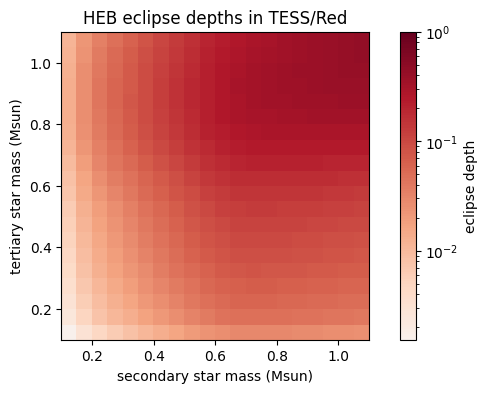

In [18]:
fig = plot_eclipse_depth_grid(mass_grid_tess, DELTA_OBS_TESS, 'TESS/Red')

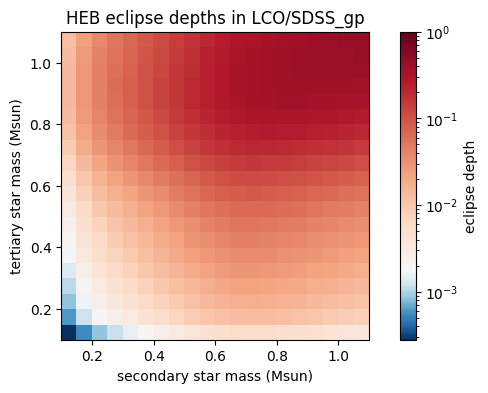

In [19]:
depth_g = 0.0018 #LCO-CPT/gp
fig = plot_eclipse_depth_grid(mass_grid_g, depth_g, 'LCO/SDSS_gp')

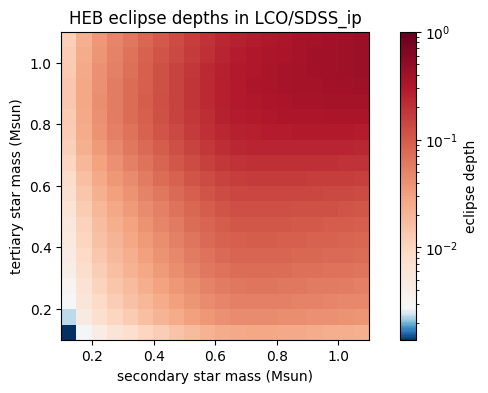

In [20]:
depth_i = 0.0028 #LCO-CTIO/ip filter 
# depth_i = 0.0012 #LCO-CTIO/ip filter 
fig = plot_eclipse_depth_grid(mass_grid_i, depth_i, 'LCO/SDSS_ip')